<a href="https://colab.research.google.com/github/milindsoorya/colab-notebooks/blob/main/ML_Pipeline_Using_Apache_Spark_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementing the Machine learning Pipeline in Spark

Implementing machine learning pipeline using Spark’s MLlib package in python.

    Spark Installation
    Data Loading
    Data Cleaning
    Features Vectors
    Model training and testing
    Model evaluation


In [ ]:
# Installing Spark

#!pip install pyspark
#!pip install findspark
import findspark
findspark.init()

In [ ]:
# Importing Libraries

import pandas as pd
import matplotlib.pyplot as plt
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

## Spark Context and Session

Before moving further, we need to create spark context. It is an entry point to our spark application where we define the configuration and cores for spark.

In [ ]:
from pyspark import SparkContext, SparkConf
# Creating a spark context class
sc = SparkSession.builder.master("local[*]").getOrCreate()


    local[*] → It creates a local session with all available cores.
    getOrCreate → If the session is not produced, only then create a new session.


### Data Loading

We are loading the US car price [dataset](https://www.kaggle.com/datasets/hashroot97/carpriceprediction) freely available on Kaggle. You can create a notebook associated with the dataset or download the dataset.

In [ ]:
# !unzip "data.csv.zip"

In [ ]:
data = sc.read.csv('./data.csv', inferSchema = True, header = True)
data.show(5)

+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
|Make|     Model|Year|    Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|   Driven_Wheels|Number of Doors|     Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity| MSRP|
+----+----------+----+--------------------+---------+----------------+-----------------+----------------+---------------+--------------------+------------+-------------+-----------+--------+----------+-----+
| BMW|1 Series M|2011|premium unleaded ...|      335|               6|           MANUAL|rear wheel drive|              2|Factory Tuner,Lux...|     Compact|        Coupe|         26|      19|      3916|46135|
| BMW|  1 Series|2011|premium unleaded ...|      300|               6|           MANUAL|rear wheel drive|              2|  Luxury,Performance|     Compact|  Convertible

In [ ]:
data.printSchema()

root
 |-- Make: string (nullable = true)
 |-- Model: string (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Engine Fuel Type: string (nullable = true)
 |-- Engine HP: integer (nullable = true)
 |-- Engine Cylinders: integer (nullable = true)
 |-- Transmission Type: string (nullable = true)
 |-- Driven_Wheels: string (nullable = true)
 |-- Number of Doors: integer (nullable = true)
 |-- Market Category: string (nullable = true)
 |-- Vehicle Size: string (nullable = true)
 |-- Vehicle Style: string (nullable = true)
 |-- highway MPG: integer (nullable = true)
 |-- city mpg: integer (nullable = true)
 |-- Popularity: integer (nullable = true)
 |-- MSRP: integer (nullable = true)



`printSchema()` It prints all the columns with their data types reasonably, saying the dataset’s schema.

### Statistical Analysis of the Dataset

In [ ]:
data.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
Make,11914,None,None,Acura,Volvo
Model,11914,745.5822222222222,1490.8280590623795,1 Series,xD
Year,11914,2010.384337753903,7.5797398875957995,1990,2017
Engine Fuel Type,11911,None,None,diesel,regular unleaded
Engine HP,11845,249.38607007176023,109.19187025917194,55,1001
Engine Cylinders,11884,5.628828677213059,1.78055934824622,0,16
Transmission Type,11914,None,None,AUTOMATED_MANUAL,UNKNOWN
Driven_Wheels,11914,None,None,all wheel drive,rear wheel drive
Number of Doors,11908,3.4360933825999327,0.8813153865835529,2,4


In [ ]:
pd_df = pd.read_csv("./data.csv")

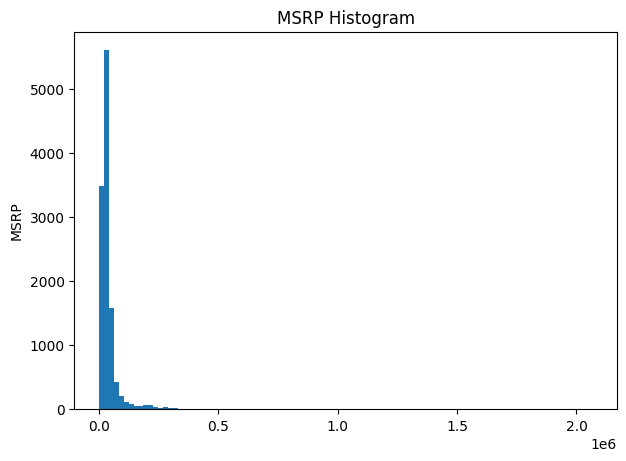

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
x = pd_df["MSRP"]
plt.hist(x, bins=100)
plt.gca().set(title='MSRP Histogram', ylabel='MSRP');

### Data Cleaning

In this step, we remove all the redundant information from our dataset. In this case, the dataset contains some NA values, and our goal is to drop the nan values.

In [ ]:
def replace(column, value):
    return column if column!=value else None

In [ ]:
from pyspark.sql.functions import when,lit,count,isnan,col
data.select([count(when(isnan(c)|col(c).isNull(),c)).alias(c) for c in data.columns]).show()

+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|Make|Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|Driven_Wheels|Number of Doors|Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|MSRP|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|   0|    0|   0|               3|       69|              30|                0|            0|              6|              0|           0|            0|          0|       0|         0|   0|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+



In [ ]:
# import sql function pyspark
import pyspark.sql.functions as f

# null values in each column
data_agg = data.agg(*[f.count(f.when(f.isnull(c), c)).alias(c) for c in data.columns])
data_agg.show()

+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|Make|Model|Year|Engine Fuel Type|Engine HP|Engine Cylinders|Transmission Type|Driven_Wheels|Number of Doors|Market Category|Vehicle Size|Vehicle Style|highway MPG|city mpg|Popularity|MSRP|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+
|   0|    0|   0|               3|       69|              30|                0|            0|              6|              0|           0|            0|          0|       0|         0|   0|
+----+-----+----+----------------+---------+----------------+-----------------+-------------+---------------+---------------+------------+-------------+-----------+--------+----------+----+



In [ ]:
#deleting the column Market Category
data = data.drop("Market Category")
# deleting the all null values 
data = data.na.drop()

In [ ]:
print((data.count(), len(data.columns)))

(11812, 15)


## Feature Vectors in Spark
Spark MLlib supports our dataset in the form of feature vectors to process it.

We need to convert our regular columnar dataset into feature vectors for fast and better convergence.

We reverse the data frame columns into feature vector series using the Class Vector Assembler.

The vector assembler will assemble all these columns’ of information into a single series that will be passed forward to our model for the activity.

In [ ]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols = ["Engine HP","Engine Cylinders",
            "Year","highway MPG","Number of Doors","city mpg","Popularity"],
                           outputCol = "Input_Attributes_name")

`outputCol`: It is the column name for the output features.

We are not calling the Vector Assembler on our data since we are creating a pipeline. We only need to pass our function; the Pipeline will transform our data on demand.

## Building the Model and Pipeline

We will be using RandomForestRegressor for our model, and later we will teach using cross-validation.


In [ ]:
from pyspark.ml.regression import RandomForestRegressor
regressor_model = RandomForestRegressor(featuresCol = 'Input_Attributes_name', labelCol = "MSRP")

RandomForestRegressor : It inputs the combination of all the features and labelCol the output feature for the training.

## Pipeline
After building a pipeline, we can save our Pipeline on disk and load it anytime.

In [ ]:
from pyspark.ml import Pipeline
pipeline  = Pipeline(stages = [assembler, regressor_model])

In [ ]:
#--Saving the Pipeline
pipeline.write().overwrite().save("pipeline_save_model")

In [ ]:
# Loading the Pipeline
pipelineModel = Pipeline.load('./pipeline_save_model')

## The cross-validation and Model Tuning

`pyspark.ml.tuning` class provides all the functions used for model tuning.

Before doing that, we need to define a hyperparameter grid used for hyperparameter tuning during cross-validation.



In [ ]:
from pyspark.ml.tuning import ParamGridBuilder
paramGrid = ParamGridBuilder().addGrid(regressor_model.numTrees, [100, 500]).build()

## Cross-Validation

We are using numFolder = 3 means 66% of the data will be used for training, and the remaining will be used for testing.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator
crossval = CrossValidator(estimator = pipelineModel,
                         estimatorParamMaps = paramGrid,
                         evaluator = RegressionEvaluator(labelCol = "MSRP"),
                         numFolds = 3)

So far, we have created a cross-validator built with a training pipeline. Now it’s time to fit/train our channel.

## Splitting the data

Splitting our data into training and testing parts by 80% for model training, and the rest 20% will be used for the validation.

In [ ]:
train_data,test_data = data.randomSplit([0.8,0.2], seed = 133)

## Training the model with data

The training process might take a bit of time, depending on the core spark used by the machine.

In [ ]:
cvModel = crossval.fit(train_data)

## Best Fit Model

bestModel : This function gives the best-fitted model after parameter tuning.



In [ ]:
bestModel = cvModel.bestModel
print(bestModel.stages)

[VectorAssembler_a19694f38f79, RandomForestRegressionModel: uid=RandomForestRegressor_02c958b73384, numTrees=100, numFeatures=7]


The best fit model we have got is having numFeatures = 7 and numTree = 100.

Inference Phase

The method transform() is used for the prediction.



In [ ]:
prediction = cvModel.transform(test_data)

The transform method automatically creates a prediction column containing all the predictions.

### Evaluation Metrics

Spark provides an Evaluator class to evaluate our model Performance, and it offers separate evaluators for the regression and classification tasks.

In [ ]:
from pyspark.ml.evaluation import RegressionEvaluator

eval = RegressionEvaluator(labelCol = 'MSRP')

rmse = eval.evaluate(prediction, {eval.metricName:'rmse'})
r2 =eval.evaluate(prediction,{eval.metricName:'r2'})
mae = eval.evaluate(prediction, {eval.metricName:"mae"})

print("RMSE: %.3f" %rmse)
print("R2: %.3f" %r2)
print("MAE: %.3f" %mae)

RMSE: 17603.061
R2: 0.913
MAE: 9006.153


R2: A higher R2 Score means a better-trained model. It tells the proportion of variance that the model can explain.

RMSE: It is the Squared mean error between the actual and predicted values.

## References

- [data-science-pipelines-and-workflow](https://www.analyticsvidhya.com/blog/2021/05/data-science-pipelines-and-workflow/)